In [1]:
pip install catboost

  Using cached catboost-1.2.5-cp311-cp311-win_amd64.whl.metadata (1.2 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB 131.3 kB/s eta 0:12:51
   ---------------------------------------- 0.0/101.1 MB 145.2 kB/s eta 0:11:37
   ---------------------------------------- 0.0/101.1 MB 140.3 kB/s eta 0:12:01
   ---------------------------------------- 0.1/101.1 MB 269.5 kB/s eta 0:06:15
   ---------------------------------------- 0.2/101.1 MB 490.7 kB/s eta 0:03:26
   ---------------------------------------- 0.3/101.1 MB 739.6 kB/s eta 0:02:17
   ---------------------------------------- 0.4/101.1 MB 969.0 kB/s eta 0:01:44
   --------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.86      0.80        98

    accuracy                           1.00     56962
   macro avg       0.87      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9727019641565123
Accuracy Score: 0.9992626663389628


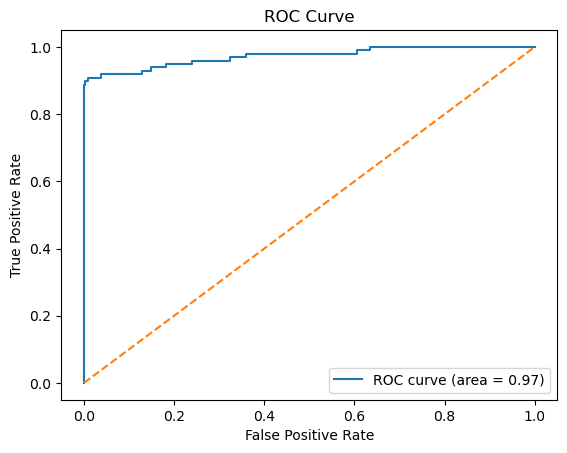

In [3]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Prepare the data
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the initial CatBoost model with basic parameters
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    class_weights=[1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])],
    verbose=False
)

# Train the initial model
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:57:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy Score: 0.9995786664794073
F1 Score: 0.8695652173913043
ROC-AUC Score: 0.9738561681003296
Precision-AUC Score: -0.875837494152815
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



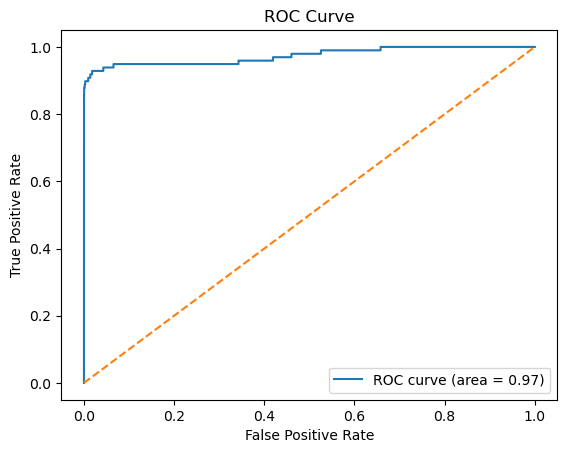

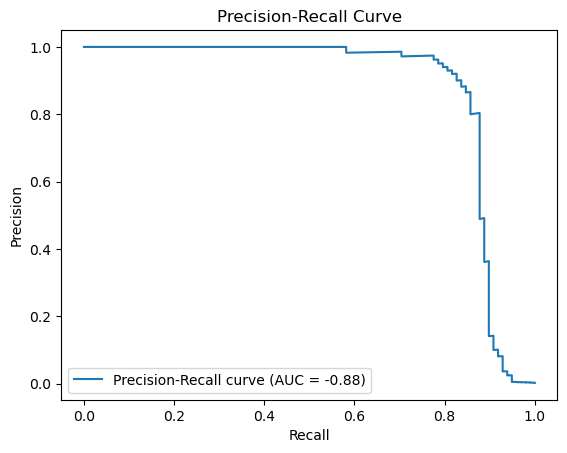

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Drop the 'Time' feature
df = df.drop(columns=['Time'])

# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train CatBoost model
catboost_model = CatBoostClassifier(learning_rate=0.1, depth=6, iterations=100, cat_features=[], random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Define and train XGBoost model
xgboost_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgboost_model.fit(X_train, y_train)

# Combine the models using VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('catboost', catboost_model),
    ('xgboost', xgboost_model)
], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
precision_auc = np.trapz(precision, recall)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Precision-AUC Score: {precision_auc}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {precision_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:59:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy Score: 0.9995611109160493
F1 Score: 0.8571428571428571
ROC-AUC Score: 0.9738369672573588
Precision-AUC Score: -0.8709046386935176
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962



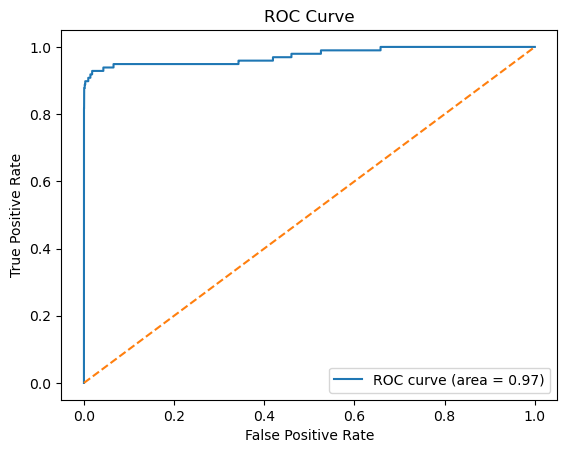

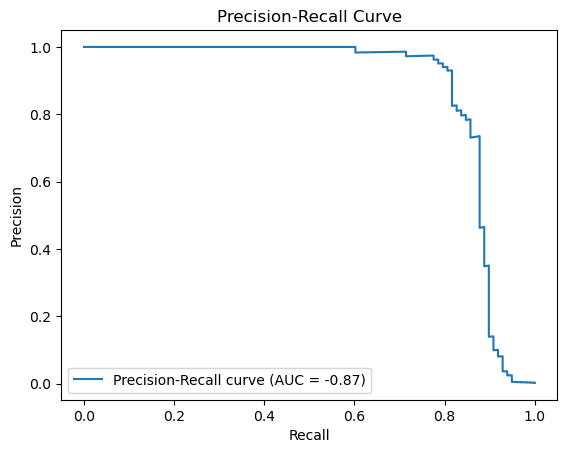

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Drop the 'Time' feature
df = df.drop(columns=['Time'])

# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train LightGBM model
lgbm_model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, random_state=42)
lgbm_model.fit(X_train, y_train)

# Define and train CatBoost model
catboost_model = CatBoostClassifier(learning_rate=0.1, depth=6, iterations=100, cat_features=[], random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Define and train XGBoost model
xgboost_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgboost_model.fit(X_train, y_train)

# Combine the models using VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('lgbm', lgbm_model),
    ('catboost', catboost_model),
    ('xgboost', xgboost_model)
], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
precision_auc = np.trapz(precision, recall)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Precision-AUC Score: {precision_auc}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {precision_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy Score: 0.998139110284049
F1 Score: 0.03636363636363636
ROC-AUC Score: 0.9728951389925694
Precision-AUC Score: -0.6655296147282693
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.17      0.02      0.04        98

    accuracy                           1.00     56962
   macro avg       0.58      0.51      0.52     56962
weighted avg       1.00      1.00      1.00     56962



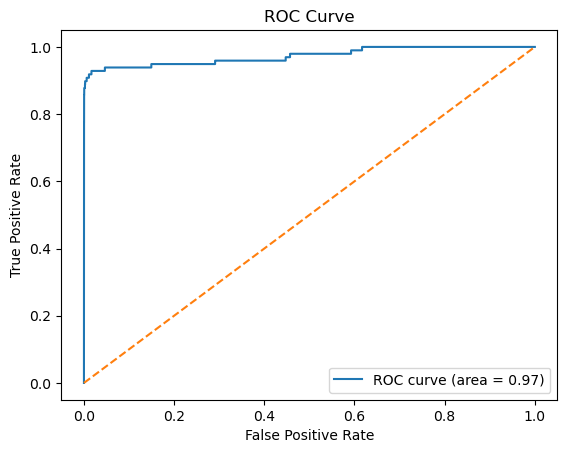

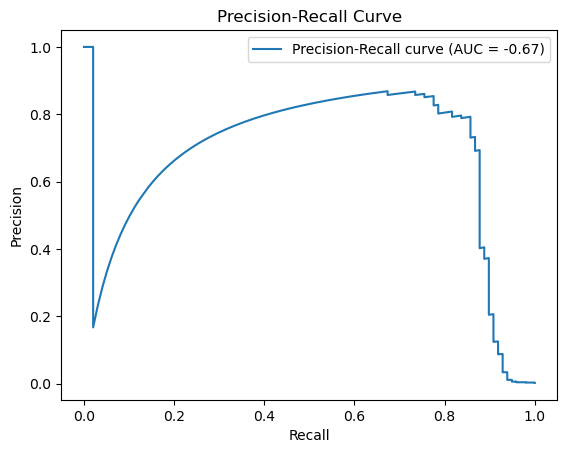

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
import xgboost as xgb

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Drop the 'Time' feature
df = df.drop(columns=['Time'])

# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train LightGBM model
lgbm_model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, random_state=42)
lgbm_model.fit(X_train, y_train)

# Define and train XGBoost model
xgboost_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgboost_model.fit(X_train, y_train)

# Combine models using VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('lgbm', lgbm_model),
    ('xgboost', xgboost_model)
], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
precision_auc = np.trapz(precision, recall)

# Print metrics
print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Precision-AUC Score: {precision_auc}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {precision_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

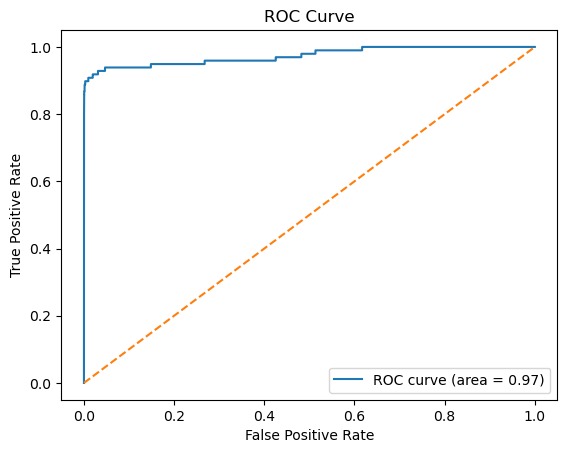

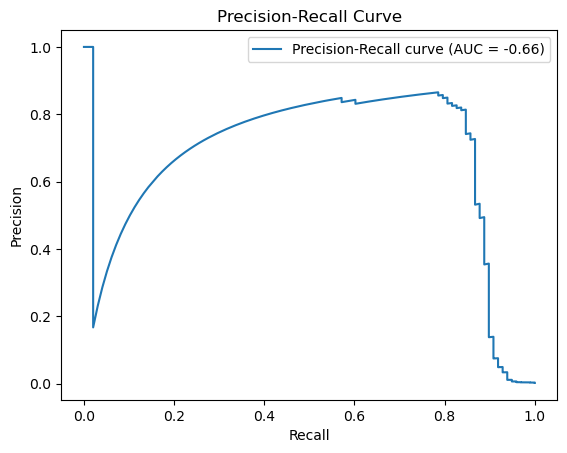

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Drop the 'Time' feature
df = df.drop(columns=['Time'])

# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train LightGBM model
lgbm_model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, random_state=42)
lgbm_model.fit(X_train, y_train)

# Define and train CatBoost model
catboost_model = CatBoostClassifier(learning_rate=0.1, depth=6, iterations=100, random_seed=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Combine models using VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('lgbm', lgbm_model),
    ('catboost', catboost_model)
], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
precision_auc = np.trapz(precision, recall)

# Print metrics
print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Precision-AUC Score: {precision_auc}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {precision_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()
